In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [3]:
#Primeiramente, o arquivo CSV será transformado em um dataframe do Pandas.

dataSet = pd.read_csv('data.csv')

In [4]:
#Vamos analisar algumas informações importantes a respeito dos dados inicialmente sem nenhum tratamento.
#dataSet.info()

Olhando para o resultado acima, podemos observar que existem 18207 linhas que deveriam conter algum dado para pelo menos um atributo. Inicialmente, é relevante retirarmos:
1 - atributos de idenficação (pois eles são de caráter subjetivo e não influenciam as variáveis que iremos analisar);
2 - atributos que a transformação para número seria difícil e subjetiva (Club, por exemplo)

In [5]:
features = [
    'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes','Weak Foot','Work Rate', 'Position', 'Preferred Foot' ,'International Reputation', 'Overall',
           'Potential','Age','Value','Wage','Skill Moves'
]

dataSetEnxuto = dataSet[features]

Alguns jogadores, provavelmente por serem recentemente adicionados, possuem valor e salário zero. Poderiamos retirar essas colunas, o que não será feito pois elas podem ser importantes para a classificação dos dados. Poderiamos calcular ou estimar esses valores, o que nos levaria a erros ou a um trabalho manual talvez desnecessário ou podemos simplesmente retirar esses jogadores.

In [6]:
counterValue = 0
counterWage = 0 

for wage in dataSetEnxuto['Wage']:
    if wage == '€0':
        counterWage += 1

for value in dataSetEnxuto['Value']:
    if value == '€0':
        counterValue += 1
        
print(counterValue + counterWage)

493


Veja que temos no máximo 493 jogadores com 'Value' ou 'Wage' igual a '€0', o que representa aproximadamente 2,7% do total de jogadores do dataSet. Dessa forma, vamos apenas retirar esses jogadores.

In [7]:
dataSetEnxuto = dataSetEnxuto[dataSetEnxuto['Wage'] != '€0']
dataSetEnxuto = dataSetEnxuto[dataSetEnxuto['Value'] != '€0']

Agora, vamos retirar o valores que estão faltando na nossa base de dados:

In [8]:
dataSetEnxuto.dropna(inplace=True)

Os atributos Preferred Foot e Position são categóricos. Por esse motivo, iremos usar dummy variables para representar seus valores numericamente:

In [9]:
atributos_categoricos = ['Position', 'Preferred Foot']

dataSetProcessado = pd.get_dummies(dataSetEnxuto, columns = atributos_categoricos, drop_first=True)

Vamos dividir a coluna 'Work Rate' em duas:

In [10]:
dataSetProcessado['Defense Work Rate'] = dataSetProcessado['Work Rate'].apply(lambda x: str(x).split('/ ')[0])
dataSetProcessado['Attack Work Rate'] = dataSetProcessado['Work Rate'].apply(lambda x: str(x).split('/ ')[-1])
dataSetProcessado.drop('Work Rate',axis=1, inplace=True)

In [11]:
#Função que converte os valores em libras para número:

def value_to_float(value):
    aux = value.split('€')[1]
    if aux[-1] == 'K':
        return float(aux[:-1])*1000
    elif aux[-1] == 'M':
        return float(aux[:-1])*1000000
    else:
        return float(aux)

In [12]:
dataSetProcessado['Value'] = dataSetProcessado['Value'].apply(value_to_float)
dataSetProcessado['Wage'] = dataSetProcessado['Wage'].apply(value_to_float)

dataSetProcessado['Defense Work Rate'] = dataSetProcessado['Defense Work Rate'].map({'Low':1,'Medium':2,'High':3})
dataSetProcessado['Attack Work Rate'] = dataSetProcessado['Attack Work Rate'].map({'Low':1,'Medium':2,'High':3})

Primeiro vamos retirar a coluna que queremos classificar do conjunto de dados processado acima:

In [13]:
X = dataSetProcessado.drop('Skill Moves',axis=1)
y = dataSetProcessado['Skill Moves']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Agora iremos utilizar o algoritmo BorutaPy para selecionar as features mais importantes do conjunto de dados.

In [15]:
#Aqui pegamos apenas os valores do Data Frame, pois o BorutaPy usa arrays do numpy.
X_train_np = X_train.values
y_train_np = y_train.values

#Criamos o objeto Random Forest que será utilizado
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Define o método de seleção de feature do Boruta
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# Encontramos as features relevantes
feat_selector.fit(X_train_np, y_train_np)

# Checamos as features escolhidas
feat_selector.support_

# Checamos a classificação das features
feat_selector.ranking_

# Vamos utilizar a função transform() em X para filtrar as features selecionadas

X_filtered = feat_selector.transform(X_train_np)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	9 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	10 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	11 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	12 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	13 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	14 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	15 / 100
Confirmed: 	38
Tentative: 	2
Rejected: 	30
Iteration: 	16 / 100
Confirmed: 	38
Tentative: 	2
Reject

In [14]:
#Use o comando abaixo pra gerar os histogramas
#X['Finishing'].hist(bins=30)

In [15]:
relevantes = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Stamina', 'Strength', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'International Reputation', 'Overall', 'Potential', 'Value', 'Wage', 'Position_GK']

X_DF_train_Filtrado = X_train[relevantes]
X_DF_test_Filtrado = X_test[relevantes]

In [35]:
#DF com as estatísticas dos dados realmente relevantes

estatisticas = X_DF_train_Filtrado.describe()

A partir daqui faremos as predições usando o KNN como classificador.

In [50]:
import sklearn.neighbors

knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=8)

Vamos usar CV para estimar melhor o valor de K a ser utilizado:

In [56]:
from sklearn.model_selection import *

In [57]:
cv_scores_knn = cross_val_score(knn_model, X_DF_train_Filtrado.values, y_train.values, cv = 5,  scoring='f1_macro')
print("Score: ",cv_scores_knn.mean(),"+/-",cv_scores_knn.std())

Score:  0.4960528445337909 +/- 0.02307429753847063


Agora vamos aplicar nosso modelo ao conjunto de teste

In [ ]:
"""
knn_model.fit(X_DF_train_Filtrado.values, y_train.values)
knn_prediction = knn_model.predict(X_DF_test_Filtrado.values)
from sklearn.metrics import f1_score
print(f1_score(y_test.values, knn_prediction, average='macro'))
"""

In [ ]:
cross_val_predict(X_DF_test_Filtrado.values, y_test.values)

Vamos usar NB pra classificar os dados:

In [59]:
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_DF_train_Filtrado.values, y_train.values)

GaussianNB(priors=None, var_smoothing=1e-09)

In [60]:
gnb_prediction = gnb_model.predict(X_DF_test_Filtrado.values)
print(f1_score(y_test.values, gnb_prediction, average='macro'))

0.25739733443409907


Crossing


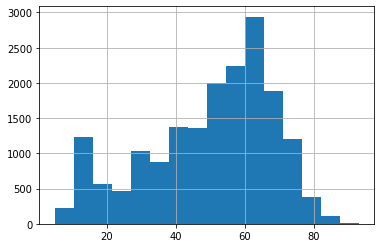

Finishing


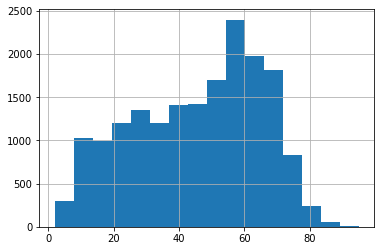

HeadingAccuracy


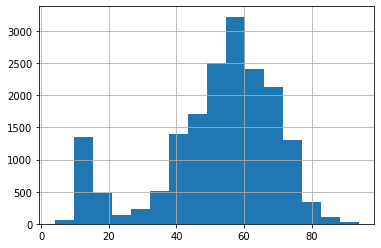

ShortPassing


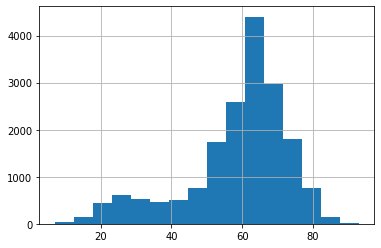

Volleys


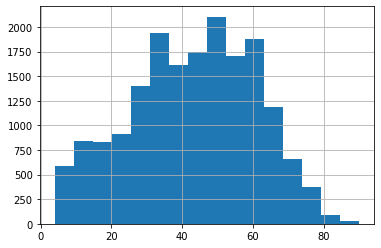

Dribbling


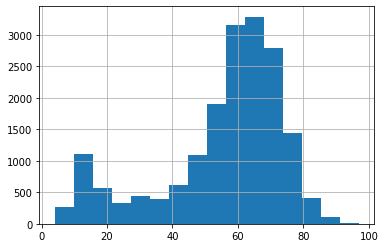

Curve


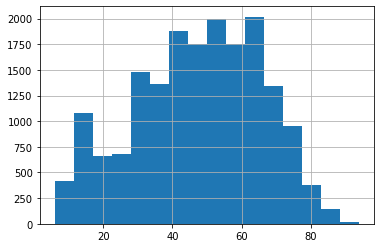

FKAccuracy


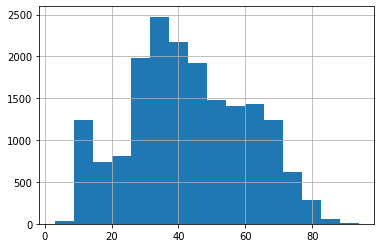

LongPassing


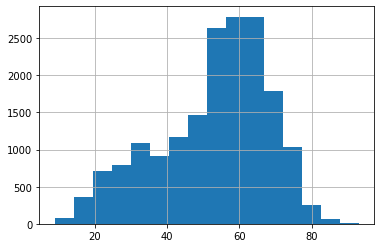

BallControl


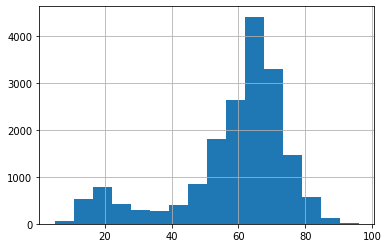

Acceleration


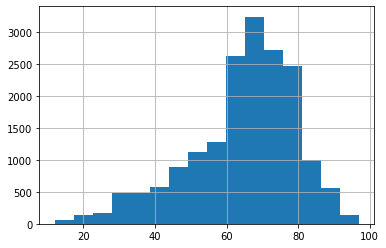

SprintSpeed


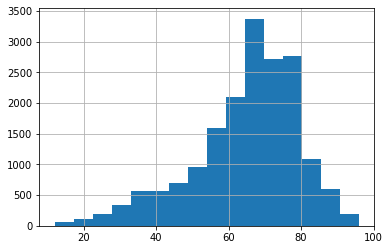

Agility


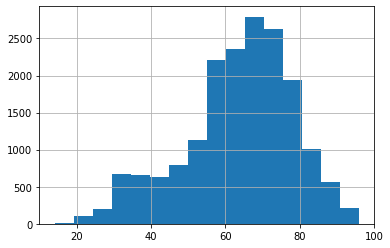

Reactions


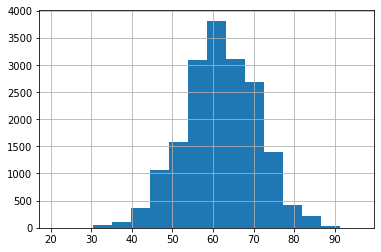

Balance


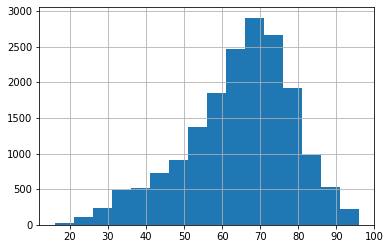

ShotPower


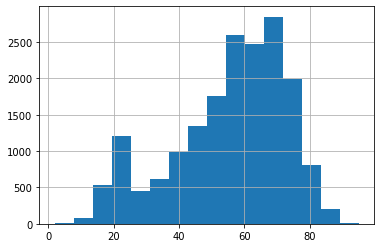

Stamina


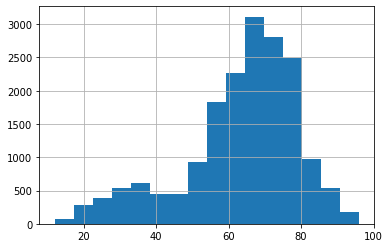

Strength


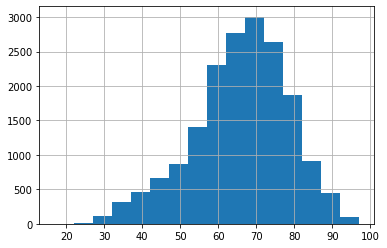

LongShots


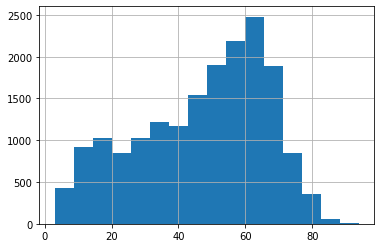

Interceptions


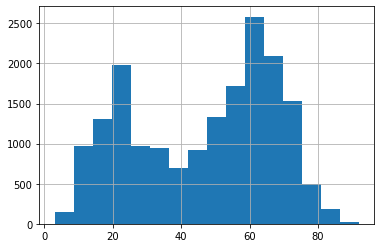

Positioning


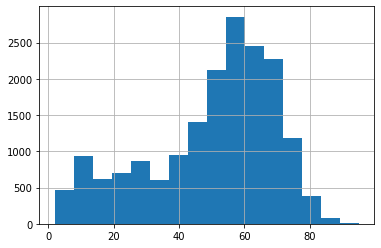

Vision


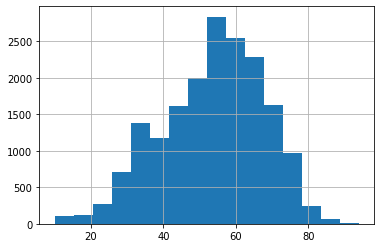

Penalties


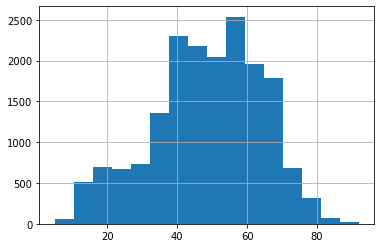

Composure


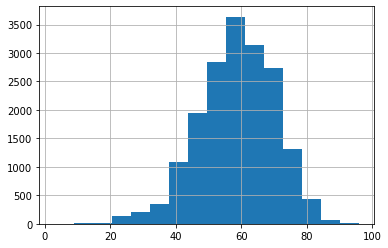

Marking


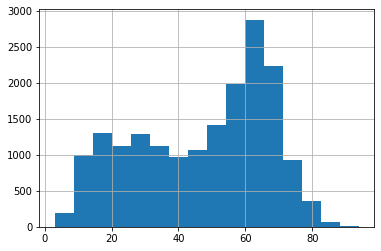

StandingTackle


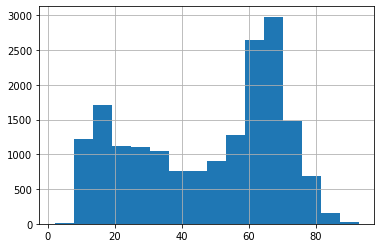

SlidingTackle


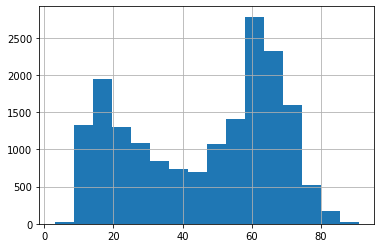

GKDiving


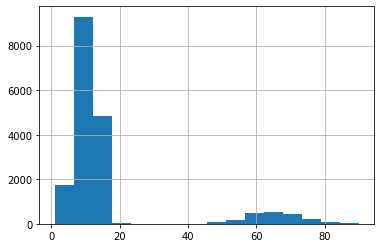

GKHandling


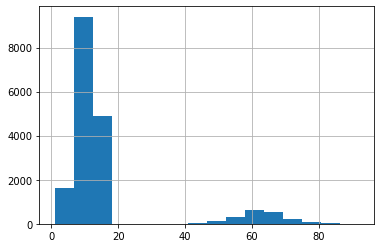

GKKicking


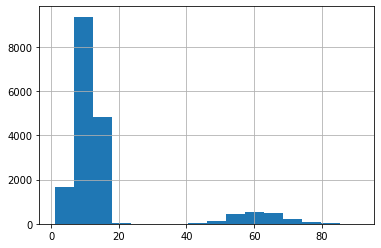

GKPositioning


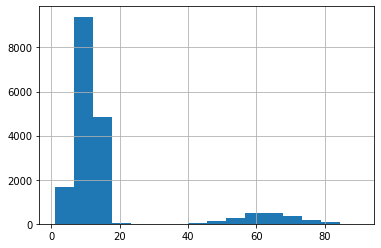

GKReflexes


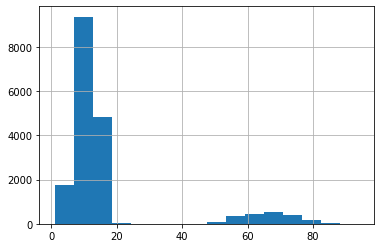

International Reputation


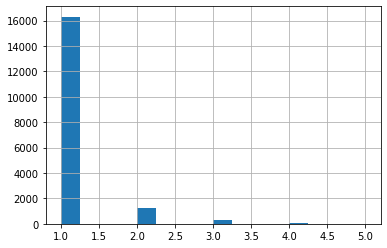

Overall


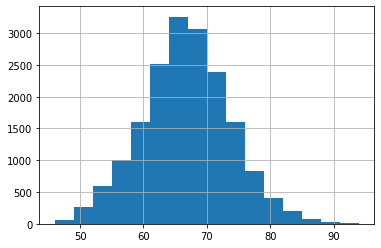

Potential


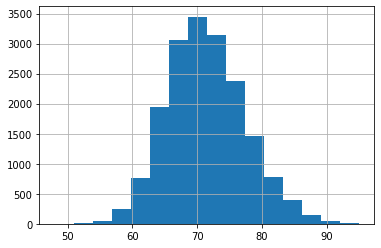

Value


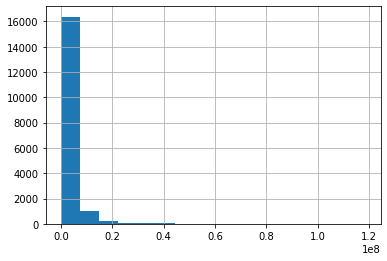

Wage


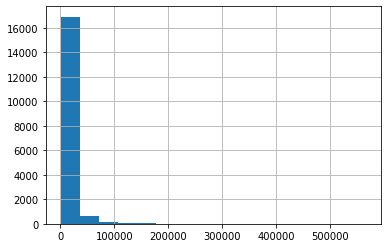

Position_GK


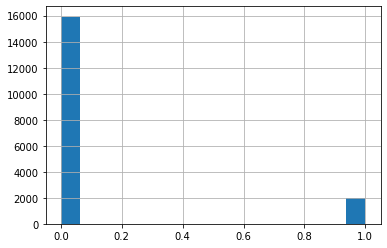

In [44]:
import statsmodels.api as sm
for features in X_DF_train_Filtrado.columns:
    print(features)
    X[features].hist(bins=16)
    plt.show()

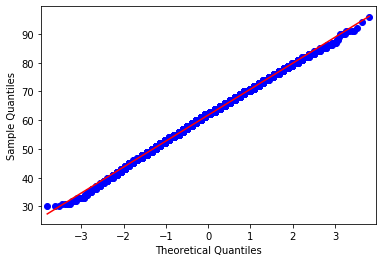

In [47]:
sm.qqplot(X_DF_train_Filtrado['Reactions'], line = 's')
plt.show()

In [37]:
estatisticas['Overall']

count    14325.000000
mean        66.209843
std          6.954098
min         46.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64